In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class ShortCorridorEnv():

  def __init__(self):
    self.state = 0

  def step(self, right):

    if self.state == 0 or self.state == 2:
        if right:
            self.state += 1
        else:
            self.state = max(0, self.state - 1)
    else:
        if right:
            self.state -= 1
        else:
            self.state += 1

    if self.state == 3:
        return 0, True
    else:
        return -1, False

  def reset(self):
        self.state = 0

In [3]:
class reinforceBaseline():

  def __init__(self, gamma, alpha, alpha_w):
    self.gamma = gamma
    self.alpha = alpha
    self.alpha_w = alpha_w
    self.w = 0

    self.theta = np.array([-1.3, 1.3])
    self.x =  np.array([[0,1],[1,0]])

    self.rewards = []
    self.actions = []

  
  def get_pi(self):

    x_theta = np.dot(self.theta, self.x)
    exp_x_theta = np.exp(x_theta - np.max(x_theta))
    p = exp_x_theta / np.sum(exp_x_theta)

    if p[np.argmin(p)] < 0.05:
        p[:] = 1 - 0.05
        p[np.argmin(p)] = 0.05

    return p

  def get_action(self, reward):

    if reward is not None:
      self.rewards.append(reward)

    right = np.random.uniform() <= self.get_pi()[1] 
    self.actions.append(right)

    return right

  def last_step(self, reward):
    self.rewards.append(reward)

    for i in range(len(self.rewards)):

      temp_lambda = 1
      G = 0.0
      for each in self.rewards[i:]:
        G += temp_lambda*each
        temp_lambda *= self.gamma

      delta = (G - self.w)

      self.w += self.alpha_w * delta
      self.theta += self.alpha * (self.gamma**i) * delta * (self.x[:, int(self.actions[i])] - np.dot(self.x, self.get_pi()))

    self.rewards = []
    self.actions = []


In [4]:
def run(gamma, alpha, alpha_w, num_episodes=1000):

    enviroment = ShortCorridorEnv()
    reinforce_baseline = reinforceBaseline(gamma, alpha, alpha_w)
    rewards = np.zeros(num_episodes)

    steps=[]
    actions = []

    for i in range(num_episodes):
      
        reward = None
        rewards_sum = 0
        enviroment.reset()

        count = 0

        while True:
            right = reinforce_baseline.get_action(reward)
            reward, done = enviroment.step(right)
            rewards_sum += reward

            actions.append(i+1)

            count+=1

            if done:
                reinforce_baseline.last_step(reward)
                steps.append(count)
                break

        rewards[i] = rewards_sum

    return rewards, reinforce_baseline.get_pi(), np.array(steps), actions

In [6]:
alpha_thetas = [ 10e-4, 2.5e-3, 5e-3, 7.5e-3, 10e-3, 2.5e-2, 5e-2]
alpha_ws = [ 10e-3, 2.5e-2, 5e-2, 7.5e-2, 10e-2, 2.5e-1, 5e-1]

total_rewards=[]
total_policies = []
total_steps = []
total_actions = []
for a_theta in alpha_thetas:
  for alpha_w in alpha_ws:
    rewards = []
    policies = []
    steps_taken = []
    actions_taken = []
    for i in tqdm(range(20)):
      reward, pi, steps, actions = run(1, alpha = a_theta, alpha_w = alpha_w)
      rewards.append(reward)
      policies.append(pi)
      steps_taken.append(steps)
      actions_taken.append(actions)
    total_rewards.append(rewards)
    total_policies.append(policies)
    total_steps.append(steps_taken)
    total_actions.append(actions_taken)


100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


In [8]:
total_rewards = np.array(total_rewards)
total_policies = np.array(total_policies)
total_steps = np.array(total_steps)
total_rewards.shape, total_policies.shape, total_steps.shape

((49, 20, 1000), (49, 20, 2), (49, 20, 1000))

In [57]:
total_policies.reshape((7,7,20,2))[1,1,:,:].mean(axis=0)

array([0.40953846, 0.59046154])

In [24]:
total_actions = np.array(total_actions)
total_actions.shape

(49, 20)

In [11]:
total_steps_ = total_steps.mean(axis=1).mean(axis=1).reshape((7, 7))

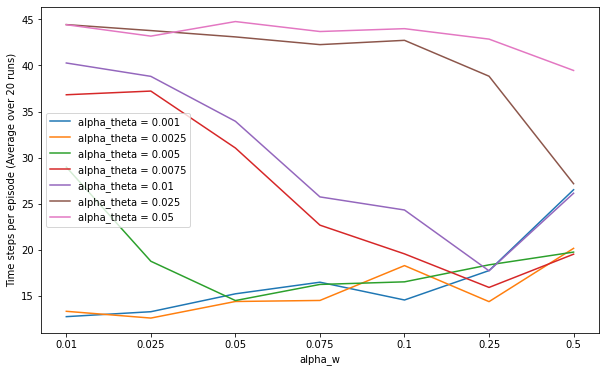

In [13]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(7):
  plt.plot(list(range(7)), total_steps_[i], label = "alpha_theta = "+str(alpha_thetas[i]))
plt.xticks(list(range(7)), alpha_ws)
plt.xlabel('alpha_w')
plt.ylabel('Time steps per episode (Average over 20 runs)')
plt.legend()
plt.show()

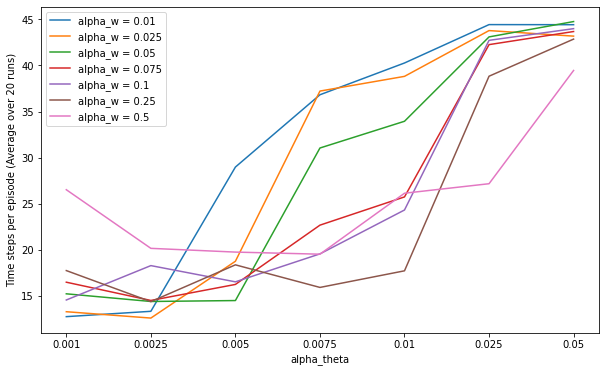

In [14]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(7):
  plt.plot(list(range(7)), total_steps_.T[i], label = "alpha_w = "+str(alpha_ws[i]))
plt.xticks(list(range(7)), alpha_thetas)
plt.xlabel('alpha_theta')
plt.ylabel('Time steps per episode (Average over 20 runs)')
plt.legend()
plt.show()

In [15]:
average_episode_reward = total_rewards.mean(axis=2).mean(axis=1).reshape((7,7))

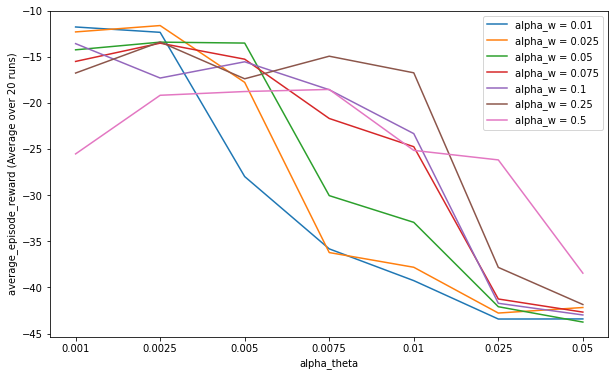

In [16]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(7):
  plt.plot(list(range(7)), average_episode_reward.T[i], label = "alpha_w = "+str(alpha_ws[i]))
plt.xticks(list(range(7)), alpha_thetas)
plt.xlabel('alpha_theta')
plt.ylabel('average_episode_reward (Average over 20 runs)')
plt.legend()
plt.show()

In [17]:
average_reward_aw_0_025 = total_rewards.reshape((7, 7, 20, 1000)).transpose((1,0,2, 3))

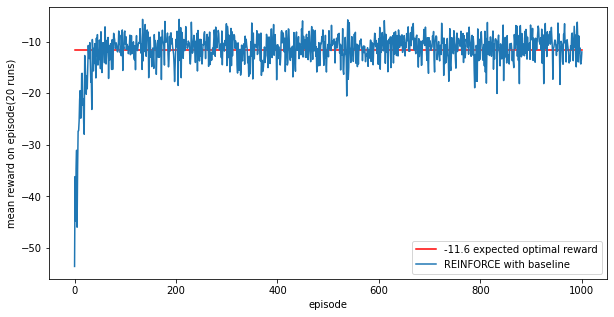

In [18]:
plt.rcParams['figure.figsize'] = (10, 5)
num_episodes = 1000
plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), color='red', label='-11.6 expected optimal reward')

x = np.linspace(0, 1000, 1000)
y = average_reward_aw_0_025[1, 1, :, :].mean(axis=0)

plt.plot(x, y, label = 'REINFORCE with baseline')

plt.ylabel('mean reward on episode(20 runs)')
plt.xlabel('episode')
plt.legend()
plt.show()

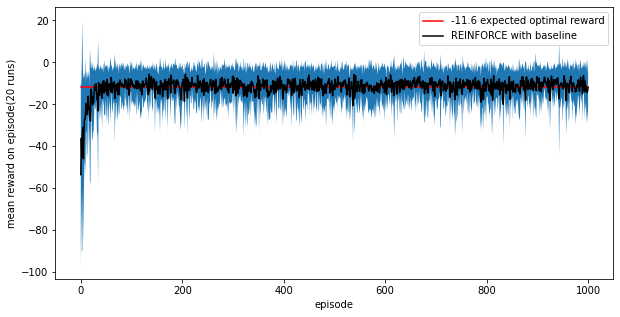

In [20]:


num_episodes = 1000
plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), color='red', label='-11.6 expected optimal reward')

x = np.linspace(0, 1000, 1000)
y = average_reward_aw_0_025[1, 1, :, :].mean(axis=0)
error = average_reward_aw_0_025[1, 1, :, :].std(axis=0)

plt.plot(x, y, '-k', label = 'REINFORCE with baseline')
plt.fill_between(x, y-error, y+error)

plt.ylabel('mean reward on episode(20 runs)')
plt.xlabel('episode')
plt.legend()
plt.show()

In [58]:
total_steps.shape

(49, 20, 1000)

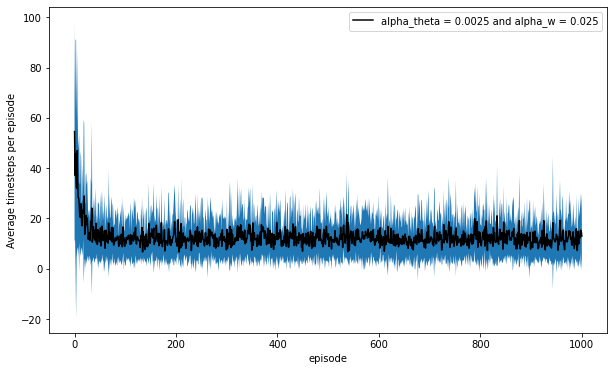

In [60]:


num_episodes = 1000

x = np.linspace(0, 1000, 1000)
y = total_steps.reshape((7,7,20,1000))[1,1,:,:].mean(axis=0)
error = total_steps.reshape((7,7,20,1000))[1,1,:,:].std(axis=0)

plt.plot(x, y, '-k', label = 'alpha_theta = 0.0025 and alpha_w = 0.025')
plt.fill_between(x, y-error, y+error)

plt.ylabel('Average timesteps per episode')
plt.xlabel('episode')
plt.legend()
plt.show()

In [26]:
total_actions.shape

(49, 20)

In [29]:
M = []
for i in range(total_actions.shape[0]):
  for j in range(total_actions.shape[1]):
    M.append(len(total_actions[i, j]))

In [30]:
min(M)

11651

In [31]:
total_actions = total_actions.reshape((7,7,20))

In [32]:
total_actions.shape

(7, 7, 20)

In [51]:
main_temp = []
for i in range(7):
  temp = []
  for each in total_actions[1, i, :]:
    temp.append(each[:10000])
  temp = np.array(temp).mean(axis=0)
  
  main_temp.append(temp)

In [52]:
np.array(main_temp).shape

(7, 10000)

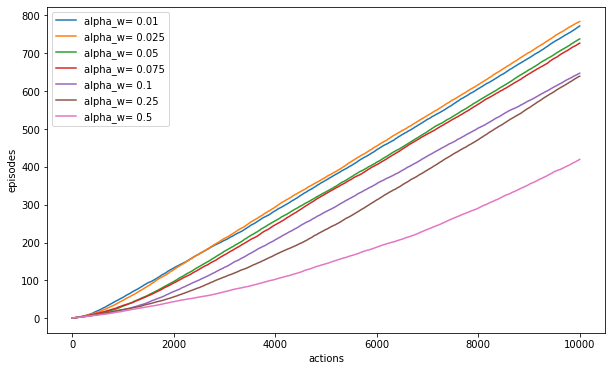

In [54]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(7):
  plt.plot(list(range(10000)), main_temp[i], label = "alpha_w= "+str(alpha_ws[i]))
plt.xlabel('actions')
plt.ylabel('episodes')
plt.legend()
plt.show()

In [55]:
main_temp = []
for i in range(7):
  temp = []
  for each in total_actions[i, 1, :]:
    temp.append(each[:10000])
  temp = np.array(temp).mean(axis=0)
  
  main_temp.append(temp)

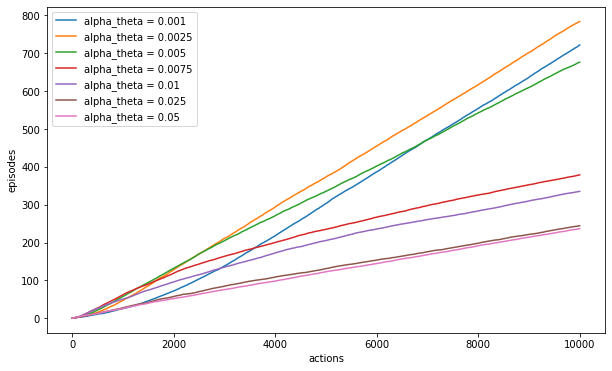

In [56]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(7):
  plt.plot(list(range(10000)), main_temp[i], label = "alpha_theta = "+str(alpha_thetas[i]))
plt.xlabel('actions')
plt.ylabel('episodes')
plt.legend()
plt.show()